Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Gasper Bizjan"

---

## Assignment 6 - Adaptive Grids


### 6.1 - Import the Grid-class
In the assignment folder you can find a python file called ```grid.py```. Import this file and create a grid called ```g``` of the unitsquare.

In [2]:
# YOUR CODE HERE
from grid import Grid
g = Grid(0,1,0,1,5,5)

### 6.2 - refined Grid
Write a class ```GridAdapter``` that handles the adaptive refinement of a grid. The constructor should have the following input:

<b> INPUT </b>: A grid ```grid```

Hint: The ```GridAdapter``` is NOT a childclass of ```Grid```. It is a class which has a grid-Class as a property.  

#### 6.2.1 Refinement

Write a function ```refine``` of this class that refines the grid of the ```GridAdapter``` adaptivly. You aren't limited in the number of helper functions.

<b> INPUT </b>:
- ```f```, a lambda function $f: \mathbb{R}^2 \longrightarrow \{true, false \}$. You should refine every cell where the evalution of $f$ at the center of the cell returns $true$.
- ```n```, an integer $n$ which gives the number of refinements. You should $n$ times refine the grid according to the value of $f$.

<b> ATTENTION </b>:
If you insert a new triangle in cells, always make sure that the numbering scheme is correct, therefore mathematically positive and starting with the index opposed to the longest edge. 

#### 6.2.2 Show

Write a property ```show``` which shows the grid.



### Hints for 6.2.1

The grid class has a new property ```isBoundaryPoint()```. You can use it to check if a inserted node is boundaryNode or not. <br>
<b>INPUT:</b> ```x``` single point ```np.array([x,y])```. <br>
<b>OUTPUT:</b> boolean. ```True``` if ```x``` is on the Boundary of the domain. 

If you need some additional inspiration you can for example use the following additional class variables and follow the plan given below:

<b> POSSIBLE ADDITIONAL CLASS VARIABLES </b>:

- ```markedCells``` list, of indices of the cells marked for the refinment.
- ```indHangingNodes``` list, where you collect the indices of all points that could be hanging nodes in the moment
- ```indHangingNodesShared``` list, where you collect the edges which could contain a hanging Node in the moment

For example: If you insert the point with index $10$ on the edge between the points $2$ and $3$ and point $10$ is no boundary point, you insert $10$ in ```indHangingNodes``` and $\lbrack 2, 3 \rbrack$ in ```indHangingNodesShared```

<b> PLAN </b>:
 
- Write a function ```markCells``` in which you construct a list with the indices of all cells which you have to refine because $f$ evaluates to true in the center of the cell

- Write a function ```refineMarkedCells``` where you iterate over all marked cells. Calculate the coordinates of the new Point. If this point exists in the points array than your are closing a hanging node. If no, add it to the points array of the grid property and add the index to the hanging nodes and update ```hangingNodesShared```, if it is not a boundary point. In any case update the cells array and be careful with the numbering.   
 
- Write a function ```markHangingCells``` which marks all the cells we have to refine to close the hanging nodes. In other words, all cells that have an edge which is contained in ```indHangingNodesShared```.  

- In your function ```refine``` mark all the cells according to the value of $f$ and refine them. After that refine all cells with hanging nodes again until there are no hanging nodes left. Repeat this $n$ times.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# YOUR CODE HERE
class GridAdapter():
    def __init__(self, grid):
        self.grid = grid
        # empty arrays for indices of cells to be refined
        self.markedCells = np.array([], dtype=np.int64)  
        self.indHangingNodes = np.array([], dtype=np.int64)
        self.HangingNodes = np.array([], dtype=np.int64)
        self.indHangingNodesShared = np.array([], dtype=np.int64) 
    
    def markCells(self, f):
        for i in range(len(self.grid.cells)):
            cell_pos_x = np.mean([
                self.grid.points[self.grid.cells][i,0][0], 
                self.grid.points[self.grid.cells][i,1][0], 
                self.grid.points[self.grid.cells][i,2][0]]) # x position of cells
            cell_pos_y = np.mean([
                self.grid.points[self.grid.cells][i,0][1], 
                self.grid.points[self.grid.cells][i,1][1], 
                self.grid.points[self.grid.cells][i,2][1]]) # y position of cells
            if f(cell_pos_x, cell_pos_y)==True: # If the function is evaluated as true, the currect cell is added
                self.markedCells = np.append(self.markedCells, self.grid.cells[i])
                self.markedCells = np.reshape(self.markedCells, (int(len(self.markedCells)/3), 3))
                
    def markHangingCells(self): # Adds cells with hanging points to MarekedCells
        for i in self.grid.cells:
            for j in self.indHangingNodesShared:
                if j[0] in i and j[1] in i:
                    self.markedCells = np.append(self.markedCells, i)
                    self.markedCells = np.reshape(self.markedCells, (int(len(self.markedCells)/3), 3))
    
    def refineMarkedCells(self):     
        for cell in self.markedCells:
            # Find point on longest edge
            edge_points = np.array([
                [self.grid.points[cell[1]], self.grid.points[cell[0]]],
                [self.grid.points[cell[2]], self.grid.points[cell[1]]],
                [self.grid.points[cell[0]], self.grid.points[cell[2]]]])
            edge_vec = np.array([
                self.grid.points[cell[1]]-self.grid.points[cell[0]],
                self.grid.points[cell[2]]-self.grid.points[cell[1]],
                self.grid.points[cell[0]]-self.grid.points[cell[2]]])
            mid_points = np.array([
                (edge_points[0][0]+edge_points[0][1])/2,
                (edge_points[1][0]+edge_points[1][1])/2,
                (edge_points[2][0]+edge_points[2][1])/2])
            new_point_ind = np.argmax(np.linalg.norm(edge_vec, axis=1))
            new_point = (edge_points[new_point_ind][0]+edge_points[new_point_ind][1])/2
            
            #If hanging node, close it, if not hanging node, add point, update hanging node lists
            if not (self.grid.points == new_point).all(axis=1).any()==True:
                self.grid.points=np.append(self.grid.points, [new_point], axis=0)
                # Check if boundary point:
                if self.grid.isBoundaryPoint(new_point)==True:
                    new_point_ind_global = len(self.grid.points) - 1
                else:
                    for j in range(len(self.grid.points)):
                        t1 = self.grid.points[j]==edge_points[new_point_ind][0]
                        t2 = self.grid.points[j]==edge_points[new_point_ind][1]
                        if t1.all() or t2.all():
                            self.indHangingNodesShared=np.append(self.indHangingNodesShared, j)
                    self.indHangingNodesShared=np.reshape(self.indHangingNodesShared, (int(len(self.indHangingNodesShared)/2), 2))
                    self.indHangingNodes=np.append(self.indHangingNodes, np.size(self.grid.points, axis=0)-1)
                    self.HangingNodes=np.append(self.HangingNodes, new_point)
                    self.HangingNodes=np.reshape(self.HangingNodes, (int(len(self.HangingNodes)/2), 2))
                    # Find the hanging node on the current cell
                    k=0
                    for i in self.HangingNodes:
                        for j in mid_points:
                            if i[0]==j[0] and i[1]==j[1]:
                                new_point_ind_global = self.indHangingNodes[k]
                        k+=1               
                    
            # Add the new cells to the cells array and delete old. 
            if self.grid.isBoundaryPoint(new_point)==True:
                self.grid.cells = np.append(self.grid.cells, [len(self.grid.points) - 1, cell[0], cell[1]])
                self.grid.cells = np.append(self.grid.cells, [len(self.grid.points) - 1, cell[2], cell[0]])
                self.grid.cells = np.reshape(self.grid.cells, (int(len(self.grid.cells)/3), 3))
                cells = self.grid.cells
                for i in range(len(cells)):
                    if cells[i][0]==cell[0] and cells[i][1]==cell[1] and cells[i][2]==cell[2]:
                        self.grid.cells = np.delete(self.grid.cells, i, axis=0)
            else: # Find the hanging node on the current cell.
                k=0
                for i in self.HangingNodes:
                    for j in mid_points:
                        if i[0]==j[0] and i[1]==j[1]:
                            new_point_ind_global = self.indHangingNodes[k]
                    k+=1 
                self.grid.cells = np.append(self.grid.cells, [new_point_ind_global, cell[0], cell[1]])
                self.grid.cells = np.append(self.grid.cells, [new_point_ind_global, cell[2], cell[0]])
                self.grid.cells = np.reshape(self.grid.cells, (int(len(self.grid.cells)/3), 3))
                cells = self.grid.cells
                for i in range(len(cells)):
                    if cells[i][0]==cell[0] and cells[i][1]==cell[1] and cells[i][2]==cell[2]:
                        self.grid.cells = np.delete(self.grid.cells, i, axis=0)
                
            # Remove current cell from markedCells
            self.markedCells=np.delete(self.markedCells, 0, axis=0)
            
    
    def refine(self, f, n=1):
        for i in range(n):
            self.markCells(f)
            while len(self.markedCells) != 0:
                self.refineMarkedCells()
                self.markHangingCells()
    
    def show(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.axis('equal')
        ax.scatter(self.grid.points[:,0] , self.grid.points[:,1])
        ax.triplot(self.grid.points[:,0], self.grid.points[:,1], self.grid.cells)
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        plt.show() 
        

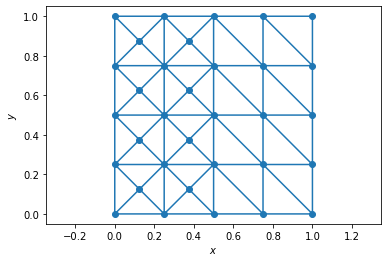

In [4]:
try:
  g = grid.Grid(0,1,0,1,5,5)
except:
  g = Grid(0,1,0,1,5,5)

adapter = GridAdapter(g)
f = lambda x,y: x

adapter.refine(f)
adapter.show()

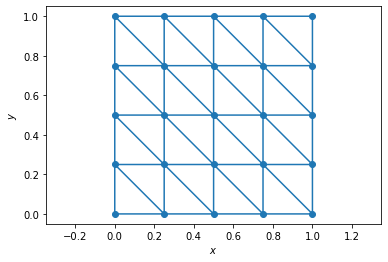

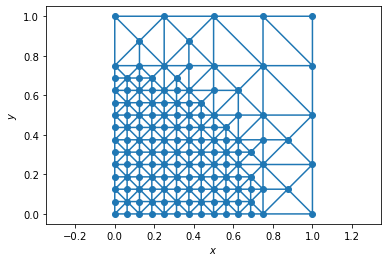

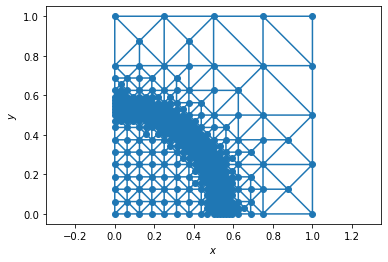

In [5]:
try:
  g = grid.Grid(0,1,0,1,5,5)
except:
  g = Grid(0,1,0,1,5,5)

adapter = GridAdapter(g)
adapter.show()

f = lambda x,y : (x**2+y**2<0.5) 
adapter.refine(f,4)
adapter.show()

f = lambda x,y : (x**2+y**2<0.35)*(x**2+y**2>0.25) 
adapter.refine(f,4)
adapter.show()